___
# Caso de aprendizaje supervisado: Problema de clasificación 

___
## Problema de absentismo en el trabajo

El departamento de recursos humanos de una empresa ha analizado los datos de sus empleados y ha descubierto que existe un problema con el absentismo. Han recabado datos y quieren realizar un modelo que clasifique correctamente a los empleados en función de si faltan más de 4 horas al mes o no. Esto les será de utilidad de cara a realizar futuras contrataciones, e incluso hacer un seguimiento a sus empleados actuales.

Los datos para la realización de este problema provienen de la University of California Irvine. Más detalles en la siguiente url: https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

Descárgate el fichero Absenteeism_at_work.csv del campus.

## Carga de librerías:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import sklearn as skl
pd.options.display.max_columns = 500

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Definición de funciones:

In [26]:
def relaciones_vs_target(X, Y, return_type='axes'):
    fig_tot = (len(X.columns))
    fig_por_fila = int(4.)
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(pos_values, neg_values, nbins, density, title):
    """Plots two histograms (positive and negative class) in the same figure."""
    plt.hist(pos_values, bins=nbins, alpha=0.5, color='blue', label='Positive', density=density)
    plt.hist(neg_values, bins=nbins, alpha=0.5, color='red', label='Negative', density=density)
    plt.title(title)
    plt.legend()

def hist_pos_neg_feat(x, y, normed=False, nbins=11, targets=(0,1)):
    """Plots histograms of features split by target class."""
    fig_tot = len(x.columns)
    fig_tot_fila = 4
    fig_tamanio = 4
    num_filas = int(np.ceil(fig_tot / fig_tot_fila))
    
    plt.figure(figsize=(fig_tot_fila * fig_tamanio + 2, num_filas * fig_tamanio + 2))
    
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1)
        plt.title(feat)
        idx_pos = y == target_pos
        idx_neg = y == target_neg
        represento_doble_hist(
            x[feat][idx_pos].values, x[feat][idx_neg].values, 
            nbins, density=bool(normed), title=feat
        )

    plt.tight_layout()
    plt.show()

## Carga de datos:

In [5]:
XY = pd.read_csv('./Absenteeism_at_work.csv', sep=';', index_col=False)

In [6]:
XY[:2]

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0


In [7]:
print('- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print('- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print('- Los nombres de las variables independientes son: {}'.format(list(XY.columns)))
XY[:2]

- El número de filas en el dataset es: 740
- El número de columnas en el dataset es: 21
- Los nombres de las variables independientes son: ['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target', 'Disciplinary failure', 'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0


## Preprocesamiento de datos: 

## Missings: 

In [8]:
XY.isnull().sum()

ID                                 0
Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

## Creación de la target 

In [9]:
XY.loc[XY['Absenteeism time in hours'] <= 4, 'target'] = 0
XY.loc[XY['Absenteeism time in hours'] > 4, 'target'] = 1
XY.drop(['Absenteeism time in hours'], axis=1, inplace=True)

## Eliminación de ids:

In [10]:
XY.drop(['ID'], axis=1, inplace=True)

## Division en features X + target Y 

In [11]:
X = XY.drop('target', axis=1)
Y = XY['target']

## Visualización y correlaciones

In [12]:
XY.describe()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,target
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,0.377027
std,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,0.484970
min,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,0.000000
50%,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,0.000000
75%,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,1.000000
max,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,1.000000


### A partir de la estadística descriptiva se pueden extraer varias conclusiones interesantes:

<b>Razón de ausencia:</b>
<br>
El “Reason for absence” varía de 0 a 28, con una mediana de 23 y un 75% de los casos en valores iguales o menores a 26. Esto indica que un porcentaje notable de empleados registra ausencias con códigos elevados (por ejemplo, el código 26), lo que podría interpretarse como un patrón de ausentismo sin justificación formal.

<b>Mes y día de ausencia:</b>
<br>
La “Month of absence” presenta una mediana de 6, lo que sugiere que las ausencias se concentran hacia mediados del año. Además, el “Day of the week” tiene una mediana de 4, lo que evidencia que los miércoles son el día en el que se produce con mayor frecuencia el ausentismo.

<b>Perfil de los colaboradores:</b>
<br>
Con una edad media de 36.45 años y un percentil 75 en torno a los 40 años, se puede inferir que los colaboradores mayores de 40 tienden a ausentarse más frecuentemente que el 70% de la plantilla. Asimismo, el “Service time” (tiempo de servicio) con mediana de 13 años sugiere una experiencia laboral considerable en la organización.

<b>Aspectos operativos y de rendimiento:</b>
<br>
El “Work load Average/day” (promedio de carga de trabajo diaria) se sitúa en torno a 271.5 minutos, mientras que el “Hit target” es elevado (mediana de 95), lo que indica que, a pesar de las ausencias, la mayoría de los empleados cumplen con sus objetivos. La escasa incidencia de “Disciplinary failure” refuerza la idea de que las ausencias no se asocian necesariamente a incumplimientos graves en el desempeño.

<b>Otros indicadores:</b>
<br>
Variables como “Transportation expense” y “Distance from Residence to Work” muestran una dispersión moderada, y en cuanto a las condiciones personales, el índice de masa corporal (BMI) medio de 26.68 sugiere que existe una tendencia hacia el sobrepeso.
Por último, la variable “target” (que podría indicar la presencia o ausencia del problema estudiado) tiene un valor medio de 0.377, lo que implica que alrededor del 38% de los casos cumplen con la condición que se busca predecir.

En conjunto, estos datos permiten entender que existe un patrón de ausentismo significativo en determinados días y meses, con una prevalencia mayor en empleados de mayor edad y con amplia experiencia, a pesar de que el rendimiento general en cuanto a metas laborales se mantiene alto.

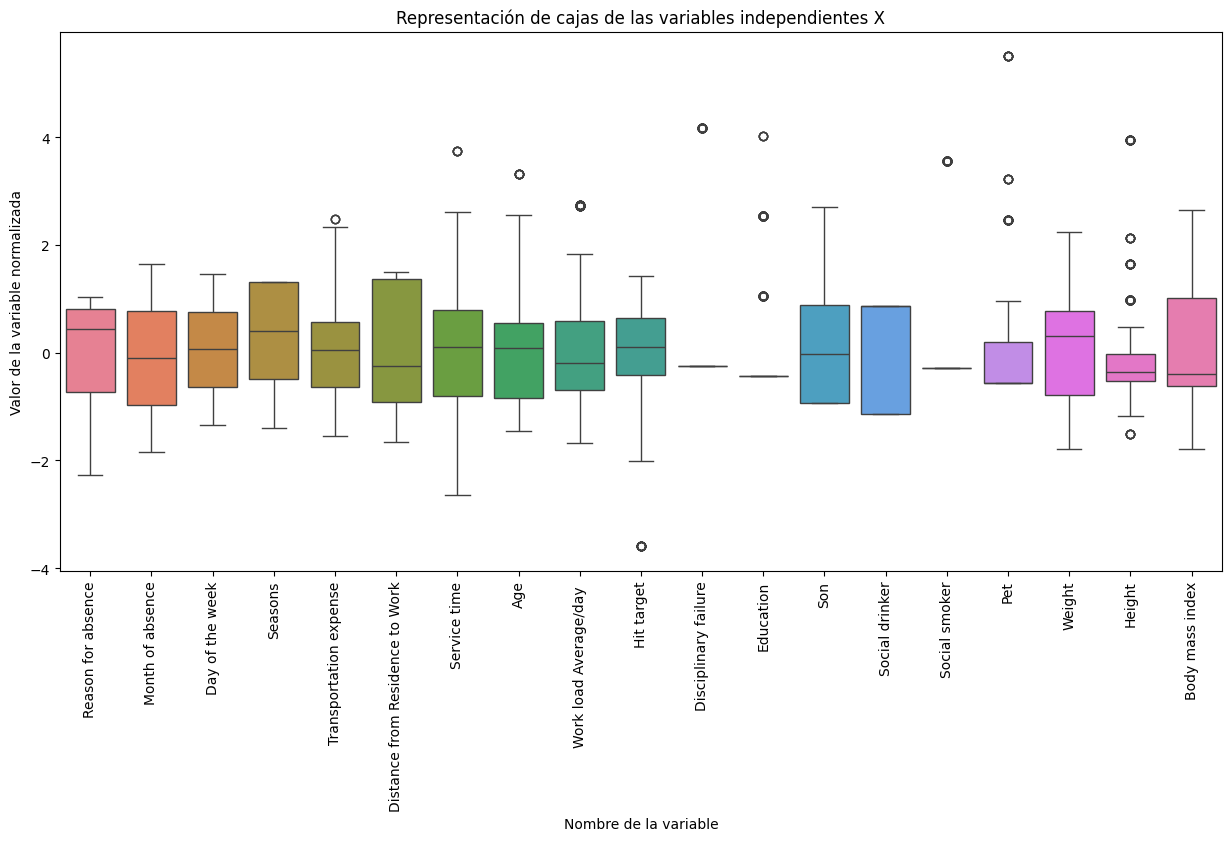

In [13]:
X_normalizado = (X-X.mean())/X.std()
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Escribe tus conclusiones sobre los boxplots.

### Análisis de Boxplots
Los boxplots nos permiten visualizar la distribución de las variables y detectar posibles valores atípicos o patrones en los datos. A continuación, detallo las observaciones clave:

1. Distribución de las Variables
   
La mayoría de las variables están concentradas cerca de la media, con algunas mostrando mayor dispersión.
Variables como "Social drinker", "Social smoker" y "Son" son discretas y probablemente binarias o categóricas con pocos valores distintos.

Otras variables, como "Reason for absence" y "Distance from Residence to Work", muestran una mayor variabilidad, lo que indica diferencias importantes en los motivos de ausencia y la distancia que los empleados recorren para ir al trabajo.


2. Identificación de Valores Atípicos
Se observan outliers en múltiples variables, principalmente en:

"Transportation expense" → Algunos empleados tienen costos de transporte significativamente más altos que el promedio.
"Son", "Social drinker" y "Pet" → Se presentan valores extremos, lo que sugiere que algunas personas tienen un número inusualmente alto en estas variables.
"Weight" y "Body mass index" → Existen empleados con pesos y niveles de IMC fuera del rango esperado, lo que podría ser relevante dependiendo del análisis final.


3. Comparación de Dispersión

Mayor dispersión:
"Transportation expense", "Distance from Residence to Work" y "Service time".
Esto indica diferencias significativas entre empleados en términos de gastos de transporte, distancia al trabajo y antigüedad en la empresa.

Menor dispersión:
"Hit target" → La mayoría de los empleados cumplen con los objetivos en un rango similar.
"Work load Average/day" → La carga laboral diaria no varía mucho entre los empleados.


4. Interpretación General

Los valores atípicos detectados podrían requerir un tratamiento adicional, dependiendo del enfoque que se quiera dar al análisis (por ejemplo, eliminarlos, transformarlos o interpretarlos como casos especiales).

Algunas variables presentan baja variabilidad, lo que podría indicar que no aportan mucha información útil al modelo y podrían ser descartadas en la fase de feature selection.

Otras, como "Distance from Residence to Work" o "Transportation expense", muestran diferencias significativas entre empleados y podrían tener un impacto importante en el ausentismo.

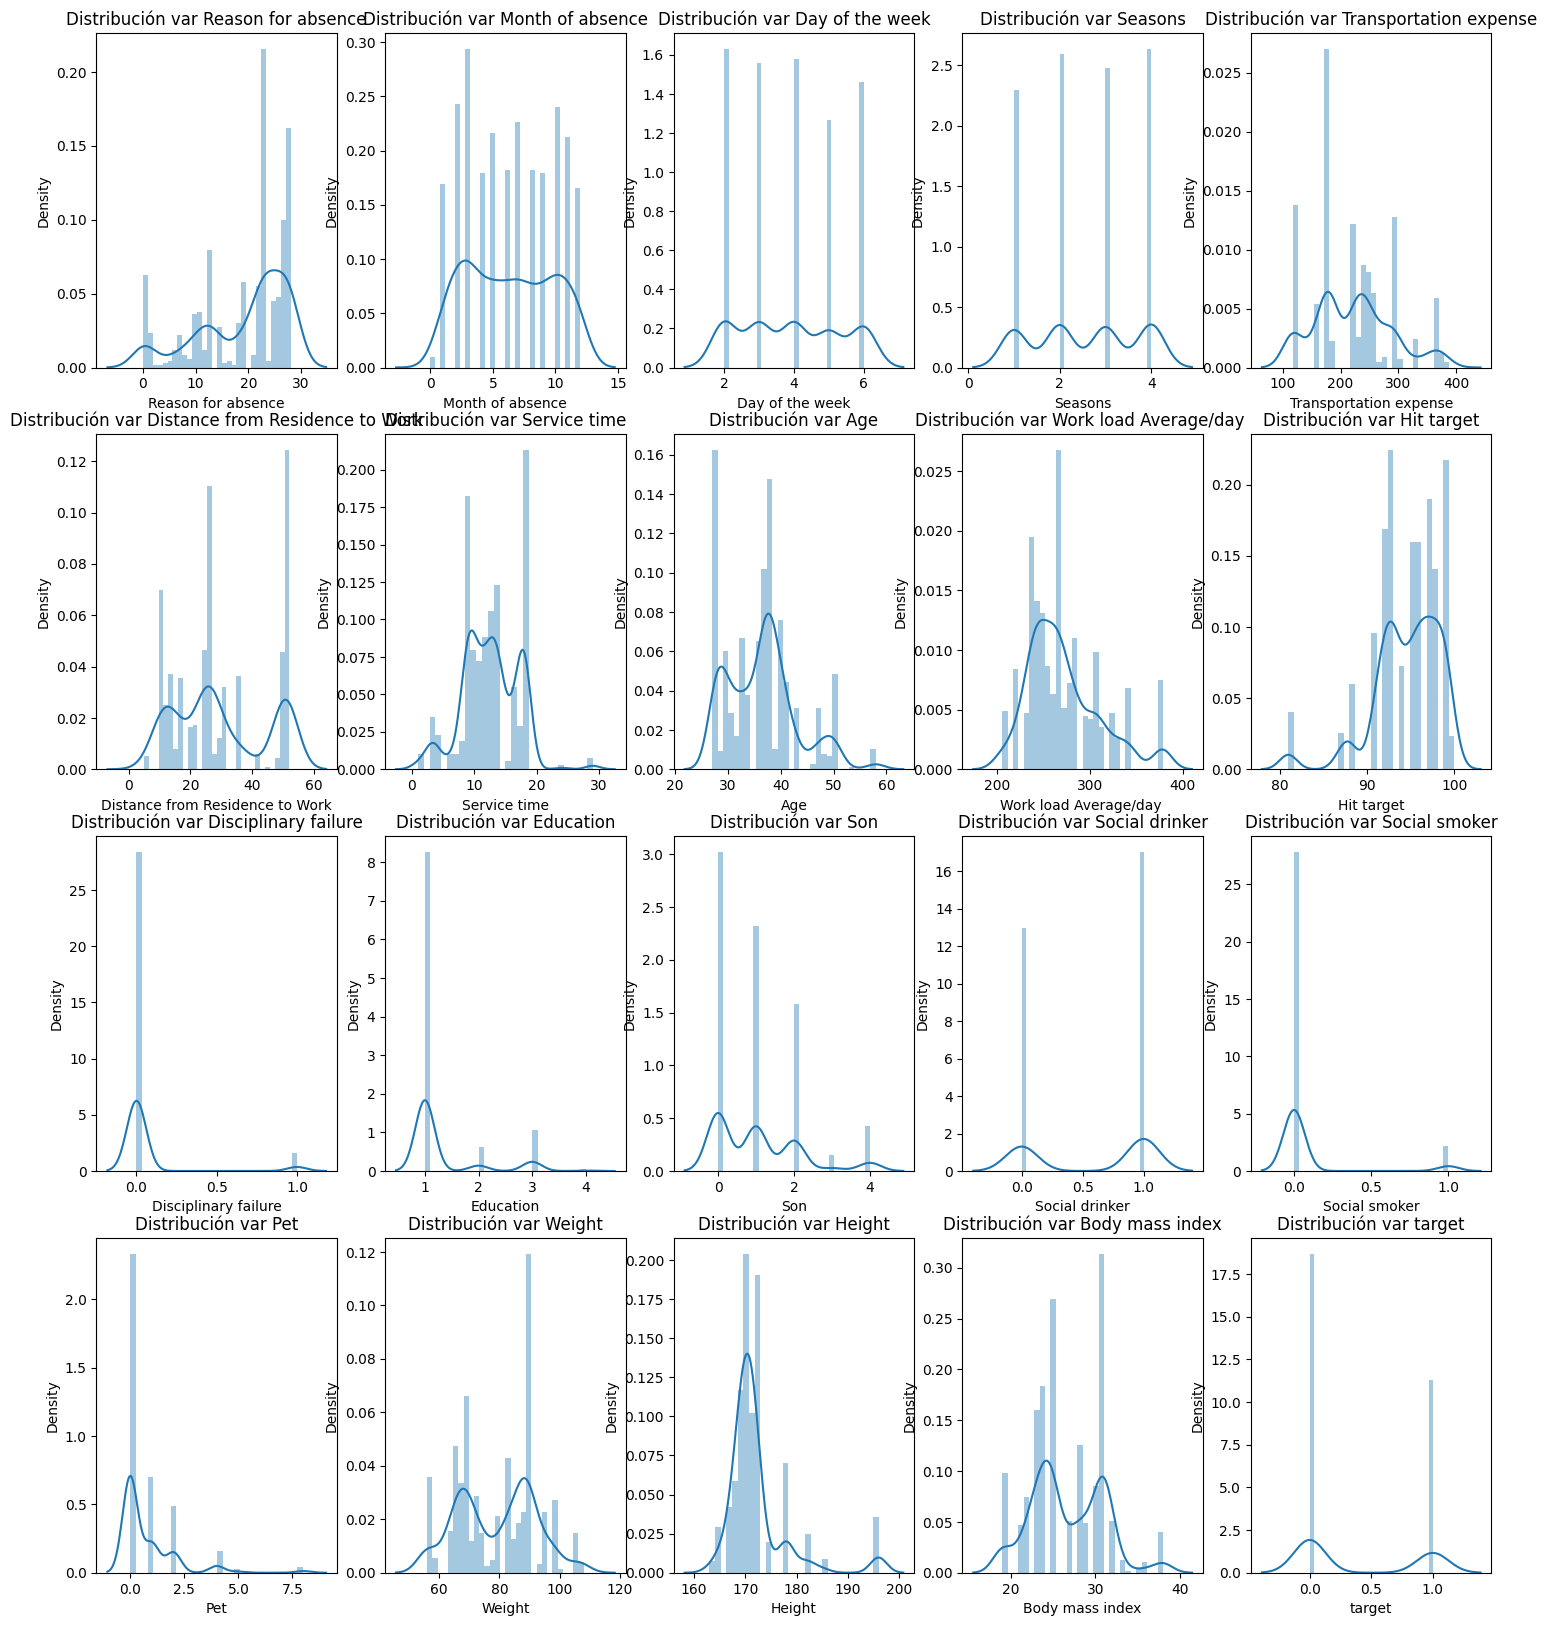

In [29]:
# Representa los histogramas de los datos completos, incluyendo la target
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(XY.columns):
    n+=1
    plt.subplot(4, 5, n)
    sns.distplot(XY[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

### **Análisis de Histogramas**  

Los histogramas nos muestran cómo se distribuyen los datos y nos ayudan a detectar patrones clave:  

- **Variables con múltiples picos:**  
  - *"Reason for absence" y "Month of absence"* → Hay ciertos motivos y meses donde las ausencias son más frecuentes.  
  - *"Seasons" y "Day of the week"* → Se nota que las ausencias tienden a concentrarse en ciertos días y estaciones.  

- **Variables sesgadas:**  
  - *"Service time" y "Age"* → Hay más empleados jóvenes y con poca antigüedad.  
  - *"Body mass index"* → Distribución irregular, con varios grupos distintos.  

- **Variables binarias o categóricas:**  
  - *"Social drinker", "Social smoker", "Disciplinary failure"* → La mayoría de los empleados están en una sola categoría.  

- **Posibles valores atípicos:**  
  - *"Transportation expense" y "Weight"* → Algunos empleados tienen gastos y pesos muy fuera del promedio.  

### **Conclusión**  
Hay patrones claros en las ausencias y algunos datos desbalanceados. También hay outliers en ciertas variables que podrían necesitar limpieza.  

## Relación variable vs target: 

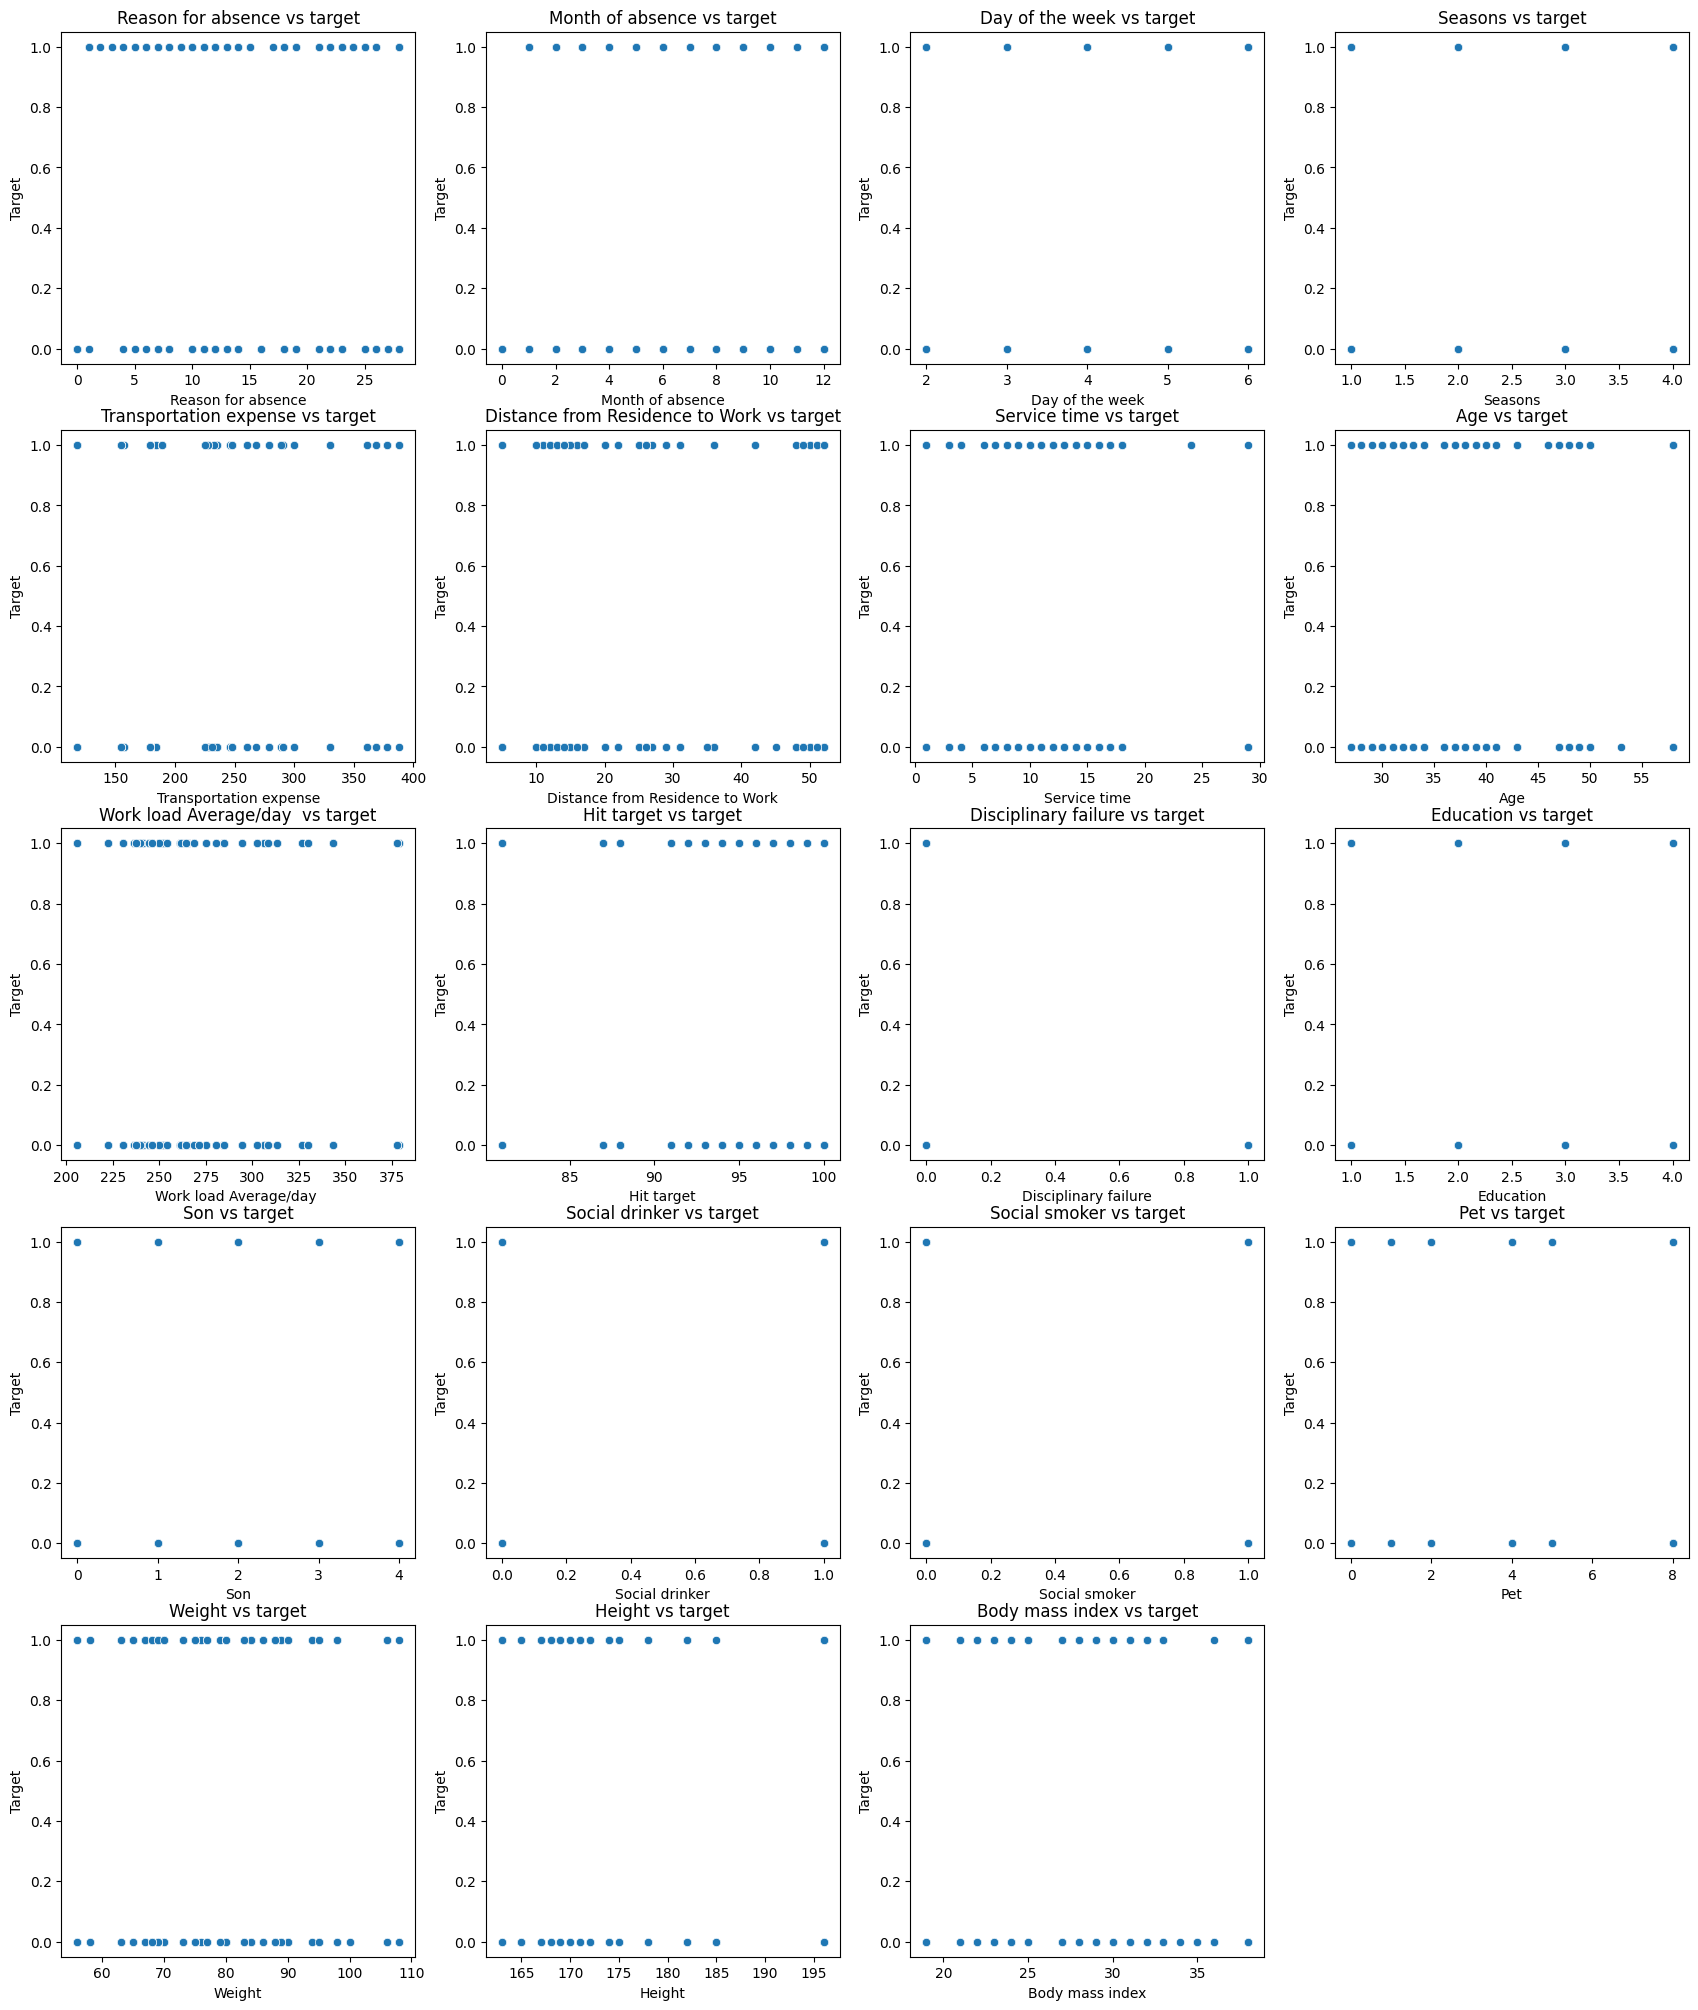

In [28]:
relaciones_vs_target(X, Y)

### Histogramas positivos-negativos

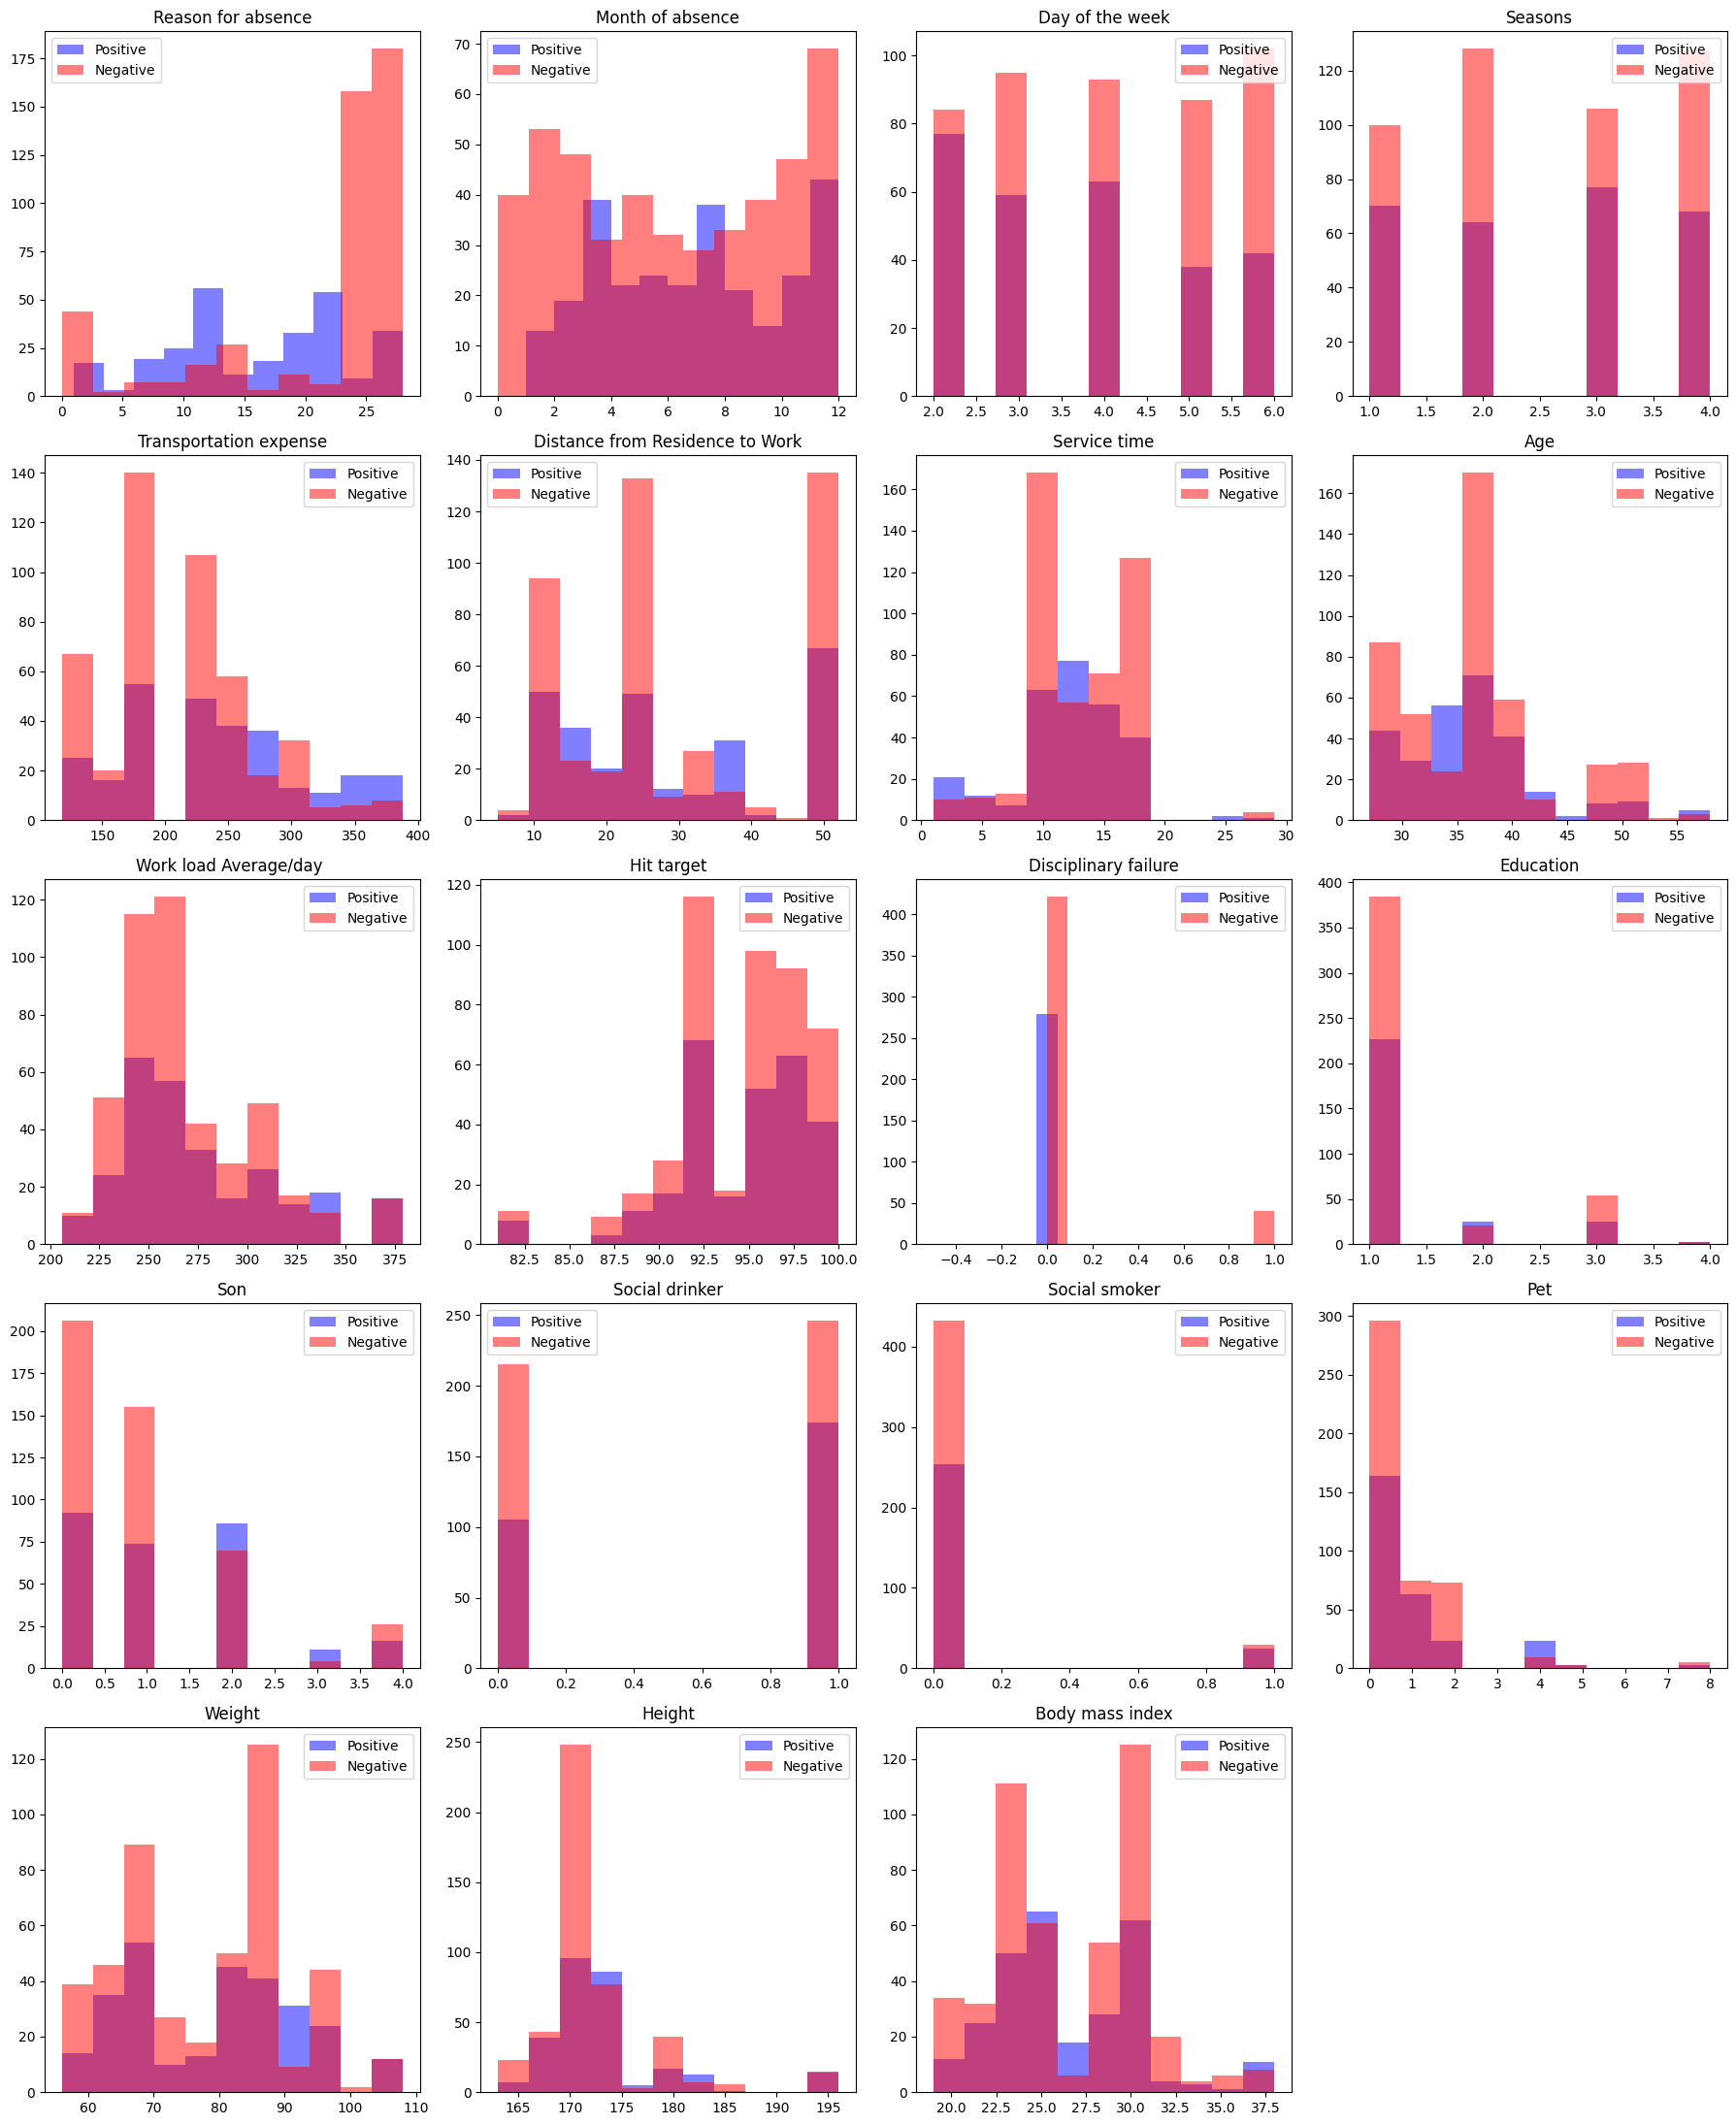

In [27]:
hist_pos_neg_feat(X,Y)

### **Comentario sobre los histogramas**  

Al analizar las distribuciones, algunas variables parecen tener más potencial para diferenciar entre las clases:  

✅ **Variables con mejor separación:**  
- **Reason for absence:** Hay ciertas razones de ausencia donde una clase es claramente más frecuente.  
- **Service time:** Se nota una diferencia en la distribución, empleados con más tiempo parecen estar más ausentes.  
- **Age:** Hay más personas mayores en la clase positiva, lo que sugiere que la edad puede influir en las ausencias.  

⚠️ **Variables con poca separación:**  
- **Day of the week y Seasons:** Distribuciones casi idénticas en ambas clases, lo que indica que estos factores no parecen influir mucho.  
- **Education y Pet:** Casi no hay diferencia entre clases, probablemente irrelevantes para el modelo.  

### **Conclusión**  
Variables como **Reason for absence, Service time y Age** parecen ser más útiles para predecir ausencias, mientras que otras como **Education o Seasons** podrían no aportar mucho valor. 🚀

### Correlation matrix

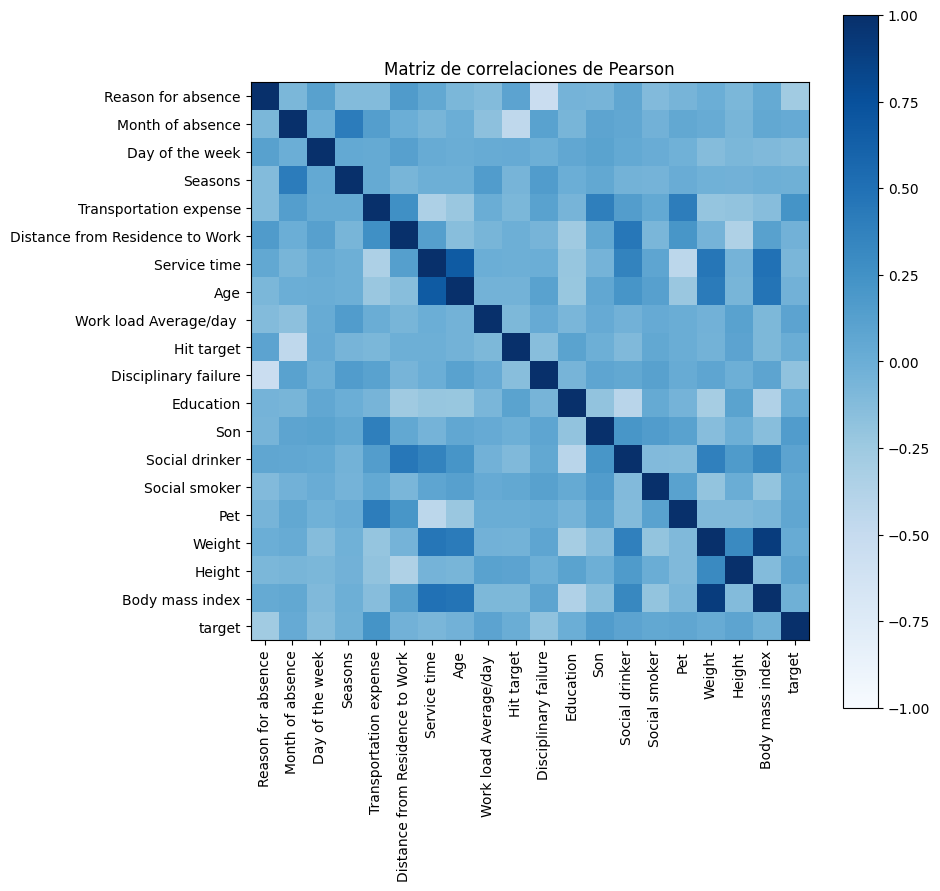

In [30]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Variables con mayor correlación con la target:

In [31]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
Reason for absence,-0.273394
Transportation expense,0.230672
Disciplinary failure,-0.185966
Son,0.149157
Day of the week,-0.131982
Social drinker,0.088076
Work load Average/day,0.086224
Height,0.079963
Service time,-0.076093
Pet,0.067480


### **Análisis de la Correlación con la Target**  

 **Variables con mayor correlación (más predictivas linealmente):**  
- **Reason for absence (-0.27)** → Tiene la correlación más fuerte (negativa), lo que sugiere que ciertos motivos de ausencia están directamente relacionados con la target.  
- **Transportation expense (0.23)** → Un mayor gasto en transporte parece estar asociado con la target, lo que puede indicar una relación con la distancia o accesibilidad al trabajo.  
- **Disciplinary failure (-0.18)** → Empleados con fallas disciplinarias tienden a estar menos ausentes, lo que puede deberse a medidas correctivas o despidos.  
- **Son (0.14)** → Tener hijos parece estar asociado a una mayor probabilidad de ausencia.  

 **Variables con menor correlación (poco predictivas linealmente):**  
- **Education (-0.0018)** → Prácticamente sin relación con la target, por lo que no parece ser un factor relevante.  
- **Hit target (0.005)** → La relación con la target es mínima, lo que indica que cumplir objetivos no está fuertemente ligado a la ausencia.  
- **Weight, BMI, Seasons, Month of absence** → Correlaciones muy bajas, por lo que es poco probable que influyan directamente en la predicción.  

### **Conclusión**  
Las variables **Reason for absence, Transportation expense y Disciplinary failure** parecen ser las más útiles para predecir ausencias de manera lineal. Por otro lado, **Education, Hit target y Weight** probablemente no aporten mucho valor al modelo si se usa regresión lineal.

## Estandarización de los datos previa: 

In [32]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test: 

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

## Aplica el modelo:

In [34]:
modelo = LogisticRegression()
modelo.fit(X_train, Y_train)

LogisticRegression()

In [35]:
y_test_pred_prob = modelo.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

np.float64(0.8300653594771241)

## Optimiza los parámetros:

In [36]:
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09], 
              "class_weight":['balanced', None]}
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [37]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.07, 'class_weight': 'balanced'} 
ROC AUC: 0.81


In [38]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

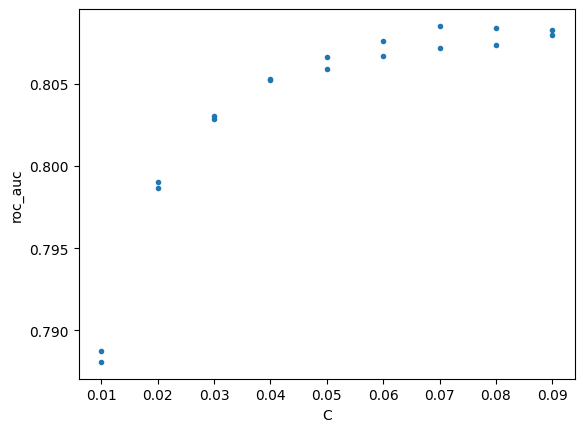

In [39]:
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

In [40]:
y_test_pred_prob = modelo_gs.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

np.float64(0.8317460317460317)

## Representación de las probabilidades

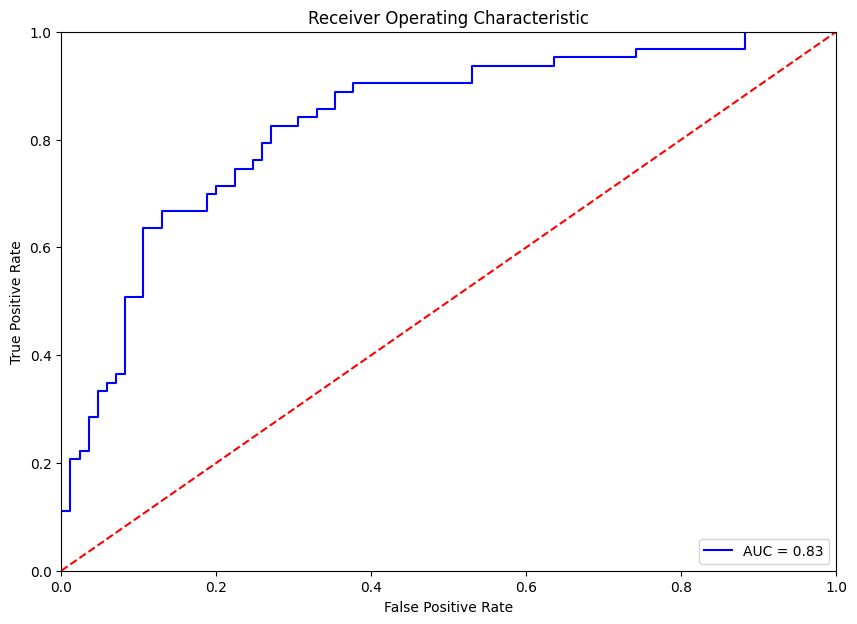

In [41]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

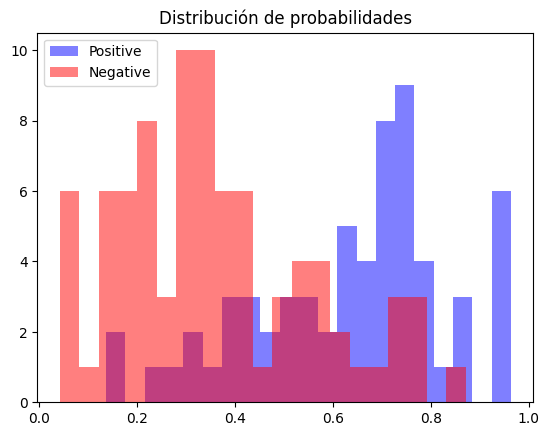

In [49]:
y_test_pred_prob = modelo_gs.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], nbins=21, density=False, title="Distribución de probabilidades")

In [45]:
sensitividades = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    sensitividades[umbral] = metrics.recall_score(Y_test, y_umbralizadas)
sensitividades

{0.1: 1.0,
 0.2: 0.9682539682539683,
 0.3: 0.9365079365079365,
 0.5: 0.7619047619047619,
 0.6: 0.6507936507936508,
 0.8: 0.1746031746031746}

In [46]:
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8,0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(Y_test, y_umbralizadas)
precisiones

{0.1: 0.44366197183098594,
 0.2: 0.48031496062992124,
 0.3: 0.5514018691588785,
 0.5: 0.6956521739130435,
 0.6: 0.7884615384615384,
 0.8: 0.9166666666666666,
 0.9: 1.0}

In [48]:
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > 0.5)
print("Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print("Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[64 21]
 [15 48]]

Accuracy	0.76
Sensitividad	0.76
Precisión	0.7
